# Stroke Classification

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
import streamlit as st
print(f'Streamlit: {st.__version__}')
import sklearn as sk
print(f'Sklearn: {sk.__version__}')

Streamlit: 1.32.0
Sklearn: 1.4.2


## Data cleaning and prep

In [3]:
stroke_df = pd.read_csv("healthcare-dataset-stroke-data.csv")
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
# make a copy so we keep the original data untouched
stroke_copy = stroke_df.copy()

In [5]:
#with na's dropped we hardly lose data so we decided to just drop NA's
stroke_copy.dropna(inplace=True)

In [6]:
#The id column is irrelevant so just decided to drop it.
stroke_copy.drop(columns=['id'], inplace=True)

In [7]:
stroke_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


### One Hot Encoding to prep data for modeling.

In [8]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

In [9]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [10]:
numerical_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [11]:
stroke_categorical = stroke_copy[categorical_columns]
stroke_numerical = stroke_copy[numerical_columns]

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
stroke_categorical = pd.DataFrame(data=ohe.fit_transform(stroke_categorical), 
                                           columns=ohe.get_feature_names_out(categorical_columns))

In [13]:
stroke_encoded = pd.concat([stroke_numerical.reset_index(drop=True), stroke_categorical.reset_index(drop=True)], axis=1)
stroke_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


In [35]:
stroke_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4909 entries, 0 to 4908
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   int64  
 2   heart_disease                   4909 non-null   int64  
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   int64  
 6   gender_Female                   4909 non-null   int64  
 7   gender_Male                     4909 non-null   int64  
 8   gender_Other                    4909 non-null   int64  
 9   ever_married_No                 4909 non-null   int64  
 10  ever_married_Yes                4909 non-null   int64  
 11  work_type_Govt_job              4909 non-null   int64  
 12  work_type_Never_worked          49

### Data training

In [14]:
X = stroke_encoded.drop(columns = 'stroke')
y = stroke_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
X_train.isna().sum()/len(stroke_encoded)

age                               0.0
hypertension                      0.0
heart_disease                     0.0
avg_glucose_level                 0.0
bmi                               0.0
gender_Female                     0.0
gender_Male                       0.0
gender_Other                      0.0
ever_married_No                   0.0
ever_married_Yes                  0.0
work_type_Govt_job                0.0
work_type_Never_worked            0.0
work_type_Private                 0.0
work_type_Self-employed           0.0
work_type_children                0.0
Residence_type_Rural              0.0
Residence_type_Urban              0.0
smoking_status_Unknown            0.0
smoking_status_formerly smoked    0.0
smoking_status_never smoked       0.0
smoking_status_smokes             0.0
dtype: float64

## Modeling 

### Random Forest

In [16]:
clf = RandomForestClassifier(random_state=42, n_estimators=500).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score: {clf.score(X_train, y_train)}')
print(f'Testing Score: {clf.score(X_test, y_test)}')

Training Score: 1.0
Testing Score: 0.9649837133550488


In [17]:
feature_importances = clf.feature_importances_

In [18]:
importances_sorted = sorted(zip(feature_importances, X.columns), reverse=True)
importances_sorted[:10]

[(0.26086793085774224, 'avg_glucose_level'),
 (0.24512993028546431, 'age'),
 (0.22356769994711542, 'bmi'),
 (0.028265592878329377, 'hypertension'),
 (0.025391169615579766, 'heart_disease'),
 (0.02047430875023474, 'Residence_type_Rural'),
 (0.02033802536901114, 'Residence_type_Urban'),
 (0.020241724777418278, 'work_type_Private'),
 (0.019813446019731302, 'smoking_status_never smoked'),
 (0.01876306697890875, 'gender_Male')]

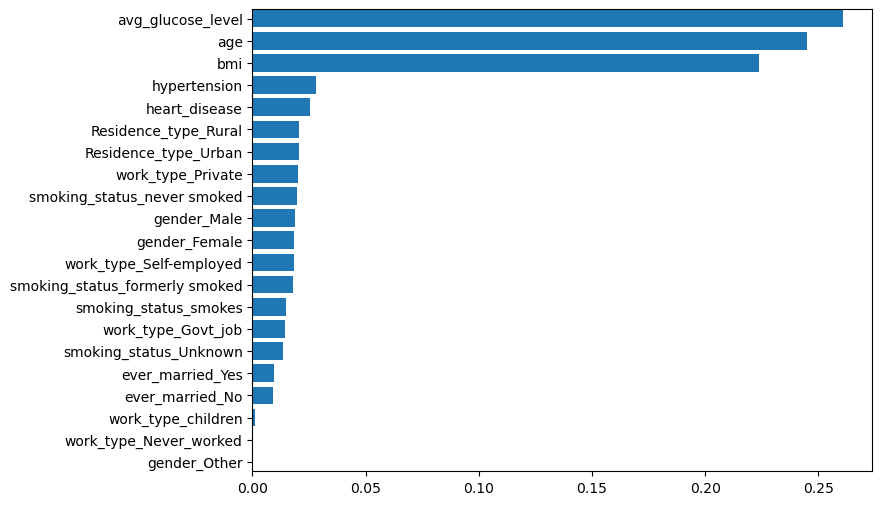

In [19]:
# Plot the feature importances
features = sorted(zip(X.columns, feature_importances), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(8,6)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

#### hyperperamater tuning

In [20]:
#initialize the model
random_tuned_model = RandomForestClassifier()
grid_tuned_model = RandomForestClassifier()
best_model = RandomForestClassifier()

In [21]:
#set params
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': [0.5, 'sqrt', 'log2', None],  
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=random_tuned_model, param_distributions=param_distributions, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_
print("Best parameters found: ", best_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}


In [22]:
random_rf_model = rf_random.best_estimator_

# Make predictions using the best model
best_rf_predictions = random_rf_model.predict(X_test)

# Evaluate the accuracy of the best model
random_accuracy = accuracy_score(y_test, best_rf_predictions)
print("Random accuracy: ", random_accuracy)

Random accuracy:  0.9657980456026058


In [23]:
param_grid = {
    'max_features': [best_params['max_features']],
    'max_depth': [max(1, best_params['max_depth'] - 10), best_params['max_depth'], best_params['max_depth'] + 10],
    'min_samples_leaf': [
        max(1, best_params['min_samples_leaf'] - 1), 
        best_params['min_samples_leaf'], 
        best_params['min_samples_leaf'] + 1
    ]
}

grid_search = GridSearchCV(estimator=grid_tuned_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters after grid search: ", grid_search.best_params_)

Best parameters after grid search:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3}


In [32]:
final_model = RandomForestClassifier(n_estimators=200,
                         min_samples_split=5,
                         min_samples_leaf=1,
                         max_depth=1,
                         max_features='sqrt',
                         bootstrap=False,
                         random_state=42
                         )
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=1, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [33]:
print(f'Training Score: {final_model.score(X_train, y_train)}')
print(f'Testing Score: {final_model.score(X_test, y_test)}')

Training Score: 0.9546318935071991
Testing Score: 0.9657980456026058


In [26]:
predictions = clf.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [27]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.9649837133550488

In [34]:
filename = 'rf.sav'
pickle.dump(final_model, open(filename, 'wb'))